In [ ]:

!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
 .master("local")\
 .appName("ClusteringApp")\
 .enableHiveSupport()\
 .config('spark.ui.port', '4050')\
 .getOrCreate()


In [ ]:
df = spark.read.csv('/content/drive/MyDrive/big data/week 3/uber.csv',inferSchema=True, header=True)

In [ ]:
df.show(5)

+----------------+-------+--------+------+
|       Date/Time|    Lat|     Lon|  Base|
+----------------+-------+--------+------+
|5/1/2014 0:02:00|40.7521|-73.9914|B02512|
|5/1/2014 0:06:00|40.6965|-73.9715|B02512|
|5/1/2014 0:15:00|40.7464|-73.9838|B02512|
|5/1/2014 0:17:00|40.7463|-74.0011|B02512|
|5/1/2014 0:17:00|40.7594|-73.9734|B02512|
+----------------+-------+--------+------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import VectorAssembler
cols = ["Lat", "Lon"]
assembler=VectorAssembler(inputCols=cols, outputCol="features")
featureDf = assembler.transform(df)
featureDf.printSchema()
featureDf.show(10)

root
 |-- Date/Time: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Lon: double (nullable = true)
 |-- Base: string (nullable = true)
 |-- features: vector (nullable = true)

+----------------+-------+--------+------+------------------+
|       Date/Time|    Lat|     Lon|  Base|          features|
+----------------+-------+--------+------+------------------+
|5/1/2014 0:02:00|40.7521|-73.9914|B02512|[40.7521,-73.9914]|
|5/1/2014 0:06:00|40.6965|-73.9715|B02512|[40.6965,-73.9715]|
|5/1/2014 0:15:00|40.7464|-73.9838|B02512|[40.7464,-73.9838]|
|5/1/2014 0:17:00|40.7463|-74.0011|B02512|[40.7463,-74.0011]|
|5/1/2014 0:17:00|40.7594|-73.9734|B02512|[40.7594,-73.9734]|
|5/1/2014 0:20:00|40.7685|-73.8625|B02512|[40.7685,-73.8625]|
|5/1/2014 0:21:00|40.7637|-73.9962|B02512|[40.7637,-73.9962]|
|5/1/2014 0:21:00|40.7252|-74.0023|B02512|[40.7252,-74.0023]|
|5/1/2014 0:25:00|40.7607|-73.9625|B02512|[40.7607,-73.9625]|
|5/1/2014 0:25:00|40.7212|-73.9879|B02512|[40.7212,-73.9879]|
+

In [ ]:
featureDf.count()
trainingData, testData = featureDf.randomSplit([0.7, 0.3], seed = 5043)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 456664
Test Dataset Count: 195771


In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [ ]:
cluster_count = [10,30,50,70,90]
for i in cluster_count:
 kmeans = KMeans().setK(i).setSeed(1).setFeaturesCol("features").setPredictionCol("prediction")
 kmeansModel = kmeans.fit(trainingData)
 for clusters in kmeansModel.clusterCenters():
  print(clusters)
 # test the model with test data set
 predictDf = kmeansModel.transform(testData)
 predictDf.show(10)
 evaluator = ClusteringEvaluator()
 silhouette = evaluator.evaluate(predictDf)
 print("Silhouette with squared euclidean distance = " + str(silhouette))

[ 40.78440111 -73.87986571]
[ 40.73136735 -73.99816839]
[ 40.6553274  -73.78267457]
[ 40.67212149 -73.98072025]
[ 40.77461643 -73.5226611 ]
[ 40.7056154  -74.18187761]
[ 40.70767738 -73.94506654]
[ 41.00821709 -73.73111464]
[ 40.76630048 -73.97310198]
[ 40.61399584 -74.44371579]
+----------------+-------+--------+------+------------------+----------+
|       Date/Time|    Lat|     Lon|  Base|          features|prediction|
+----------------+-------+--------+------+------------------+----------+
|5/1/2014 0:01:00| 40.694|-73.9872|B02598| [40.694,-73.9872]|         3|
|5/1/2014 0:01:00|40.7469|-73.9884|B02682|[40.7469,-73.9884]|         1|
|5/1/2014 0:02:00|40.7106|-73.9662|B02598|[40.7106,-73.9662]|         6|
|5/1/2014 0:02:00|40.7487|-74.0035|B02682|[40.7487,-74.0035]|         1|
|5/1/2014 0:02:00|40.7509|-74.0036|B02617|[40.7509,-74.0036]|         1|
|5/1/2014 0:02:00|40.7521|-73.9914|B02512|[40.7521,-73.9914]|         1|
|5/1/2014 0:03:00|40.6482| -73.783|B02682| [40.6482,-73.783]|  

In [20]:
# test the model with test data set
predictDf = kmeansModel.transform(testData)
predictDf.show(10)
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictDf)
print("Silhouette with squared euclidean distance = " + str(silhouette))

+----------------+-------+--------+------+------------------+----------+
|       Date/Time|    Lat|     Lon|  Base|          features|prediction|
+----------------+-------+--------+------+------------------+----------+
|5/1/2014 0:01:00| 40.694|-73.9872|B02598| [40.694,-73.9872]|        51|
|5/1/2014 0:01:00|40.7469|-73.9884|B02682|[40.7469,-73.9884]|        35|
|5/1/2014 0:02:00|40.7106|-73.9662|B02598|[40.7106,-73.9662]|        49|
|5/1/2014 0:02:00|40.7487|-74.0035|B02682|[40.7487,-74.0035]|        77|
|5/1/2014 0:02:00|40.7509|-74.0036|B02617|[40.7509,-74.0036]|        77|
|5/1/2014 0:02:00|40.7521|-73.9914|B02512|[40.7521,-73.9914]|        30|
|5/1/2014 0:03:00|40.6482| -73.783|B02682| [40.6482,-73.783]|        11|
|5/1/2014 0:04:00|40.7187|-74.0059|B02617|[40.7187,-74.0059]|        28|
|5/1/2014 0:04:00|40.7313|-73.9747|B02682|[40.7313,-73.9747]|        69|
|5/1/2014 0:04:00|40.7623|-73.9863|B02617|[40.7623,-73.9863]|         5|
+----------------+-------+--------+------+---------

In [21]:
predictDf.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|        31|    1|
|        85|  368|
|        65|  784|
|        53|  696|
|        78|   84|
|        34|  161|
|        81|   25|
|        28| 6426|
|        76|    2|
|        27|   53|
|        26|   57|
|        44|10276|
|        12| 2498|
|        22|  546|
|        47| 4775|
|         1|  422|
|        52|   46|
|        13|  148|
|         6| 3696|
|        16|   81|
+----------+-----+
only showing top 20 rows



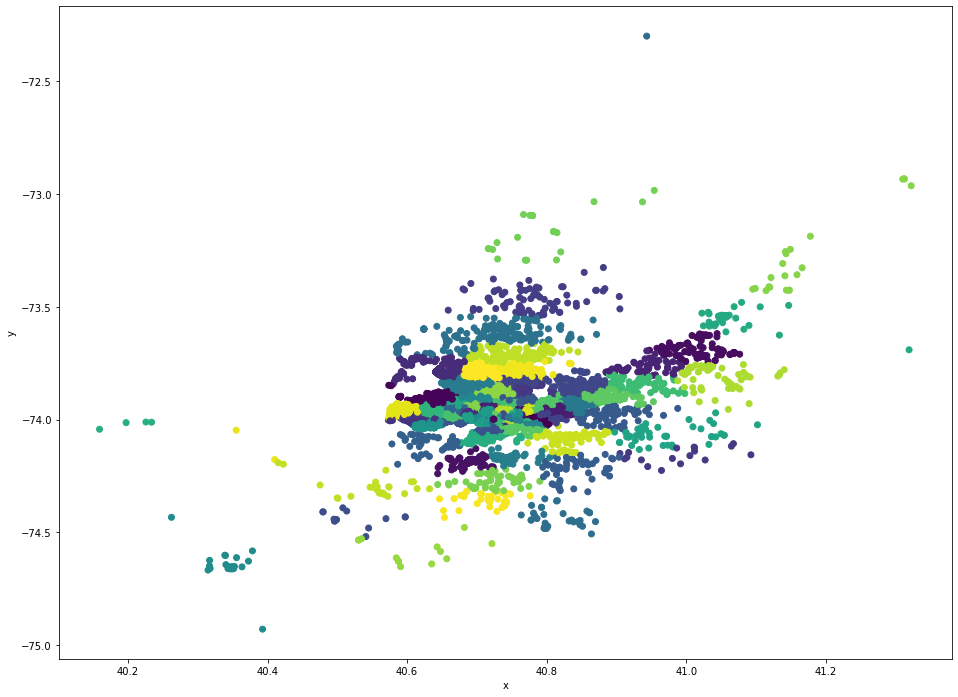

<Figure size 864x720 with 0 Axes>

In [26]:
import matplotlib.pyplot as plt
pddf_pred = predictDf.toPandas()
pddf_pred.head()
fig = plt.figure(figsize=(16,12))
KmVis= fig.add_subplot(111)
threedee = plt.figure(figsize=(12,10))
KmVis.scatter(pddf_pred.Lat, pddf_pred.Lon, c=pddf_pred.prediction)
KmVis.set_xlabel('x')
KmVis.set_ylabel('y')
plt.show()
